In [12]:
%reset

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import shutil

print('Imported libraries')

Imported libraries


In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
# Define hyperparameters
num_epochs = 10
batch_size = 4
learning_rate = 0.001
load_model = False

In [16]:
# Define transformation to randomly augment image data
transformer = transforms.Compose([
    transforms.Resize([200,200]), # to ensure all images are the same size
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(), # 0-255 to 0-1, numpy to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 0-1 to [-1,1], formula (x-mean)/std
])

In [17]:
# Load dataset
train_path = '../Datasets/asl_alphabet_train/'
# test_path = '../Datasets/asl_alphabet_test/'

full_dataset = ImageFolder(root=train_path,
                           transform=transformer)

train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

# train_size = 5000
# test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=4,
                         shuffle=True)

In [18]:
# Define classes
classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 
           'H', 'I', 'J', 'K', 'L', 'M', 'N', 
           'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 
           'T', 'U', 'V', 'W', 'X', 'Y', 'Z')
print(classes)

('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')


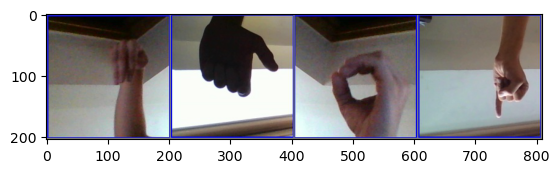

In [19]:
# Show random training images
def show_image(img):
    img = img / 2 + 0.5 # unnormalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
show_image(torchvision.utils.make_grid(images))

In [20]:
# CNN Model

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 47 * 47, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 28)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 47 * 47)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('Saving checkpoint...')
    torch.save(state,filename)
    print('Checkpoint saved')

def load_checkpoint(checkpoint, model, optimizer):
    print('Loading checkpoint...')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Checkpoint loaded')

In [24]:
# Training the model
model = ConvNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Load saved model to continue training
# checkpoint = torch.load('model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.to(device)
if load_model:
    load_checkpoint(torch.load('checkpoint.pth.tar'))

# Train model
model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    losses = []
    
    if epoch % 2 == 0:
        checkpoint = {'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Load data onto device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    mean_loss = sum(losses) / len(losses)
    print(f'Loss at Epoch {epoch+1} was {mean_loss:.5f}')

print('Finished Training')

# for param in model.parameters():
#     print(param)

FILE = 'model.pth'
torch.save(model.state_dict(), FILE)

# loaded_model = ConvNet().to(device)
# loaded_model.load_state_dict(torch.load(FILE))
# loaded_model.eval()

# for param in loaded_model.parameters():
#     print(param)

Saving checkpoint...
Checkpoint saved
Epoch [1/10], Step [100/14700], Loss: 3.3317
Epoch [1/10], Step [200/14700], Loss: 3.3319
Epoch [1/10], Step [300/14700], Loss: 3.3343
Epoch [1/10], Step [400/14700], Loss: 3.3688
Epoch [1/10], Step [500/14700], Loss: 3.2917
Epoch [1/10], Step [600/14700], Loss: 3.3154
Epoch [1/10], Step [700/14700], Loss: 3.3317
Epoch [1/10], Step [800/14700], Loss: 3.3024
Epoch [1/10], Step [900/14700], Loss: 3.3317
Epoch [1/10], Step [1000/14700], Loss: 3.3407
Epoch [1/10], Step [1100/14700], Loss: 3.2840
Epoch [1/10], Step [1200/14700], Loss: 3.3524
Epoch [1/10], Step [1300/14700], Loss: 3.3442
Epoch [1/10], Step [1400/14700], Loss: 3.3169
Epoch [1/10], Step [1500/14700], Loss: 3.3061
Epoch [1/10], Step [1600/14700], Loss: 3.2932
Epoch [1/10], Step [1700/14700], Loss: 3.3225
Epoch [1/10], Step [1800/14700], Loss: 3.3039
Epoch [1/10], Step [1900/14700], Loss: 3.3294
Epoch [1/10], Step [2000/14700], Loss: 3.3049
Epoch [1/10], Step [2100/14700], Loss: 3.3496
Epoch

In [33]:
for images, labels in test_loader:
    print(labels)
    break

tensor([19, 24,  1,  2])


In [34]:
# Test model & calculate accuracy
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(28)]
    n_class_samples = [0 for i in range(28)]

    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # for i in range(batch_size):
        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(28):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 95.97238204833141 %
Accuracy of A: 93.65256124721604 %
Accuracy of B: 92.84140969162996 %
Accuracy of C: 97.08520179372198 %
Accuracy of D: 94.90373725934315 %
Accuracy of E: 91.91343963553531 %
Accuracy of F: 96.50273224043715 %
Accuracy of G: 95.89905362776025 %
Accuracy of H: 98.54260089686099 %
Accuracy of I: 96.85807150595883 %
Accuracy of J: 99.78260869565217 %
Accuracy of K: 93.31103678929766 %
Accuracy of L: 97.26962457337883 %
Accuracy of M: 95.15086206896552 %
Accuracy of N: 98.97025171624713 %
Accuracy of nothing: 96.65587918015102 %
Accuracy of O: 98.01255230125523 %
Accuracy of P: 99.1130820399113 %
Accuracy of Q: 97.43016759776536 %
Accuracy of R: 95.16129032258064 %
Accuracy of S: 96.60249150622876 %
Accuracy of space: 92.21967963386727 %
Accuracy of T: 84.11111111111111 %
Accuracy of U: 93.14606741573034 %
Accuracy of V: 97.46543778801843 %
Accuracy of W: 98.03063457330416 %
Accuracy of X: 97.31182795698925 %
Accuracy of Y: 99.66292134831461 %
A